# Examples: General usage and classes

In this notebook, some basic usage examples for the dsptools package are given.

The main idea behind the package is that the user does not have to pass vectors around explicitely. There should always be a higher-level function for general things that handles assertions, sampling rates and multi-channel processing.

### Contents
1. The `Signal` class
2. The `MultiBandSignal` class
3. The `Filter` class
4. The `FilterBank` class

## 1. The `Signal` class

In [1]:
import dsptoolbox as dsp
from os.path import join
import os
import soundfile as sf
%matplotlib inline

### Importing and exporting data

In [2]:
# ========== Importing ========================================================
# Give path to data directly, wav and flac are supported
speech = dsp.Signal(
    path=join('data', 'speech.flac'), time_data=None, sampling_rate_hz=None,
    # Optional parameters:
    signal_type='general',  # Type of signal
    signal_id='here is some random info or id about the signal')
# If a path is given, time_data and sampling rate should be set to None

# If you already have time data as vector, it can be passed to Signal 
# constructor. In that case, path should be set to None.
audio, fs = sf.read(join('data', 'speech.flac'))
speech = dsp.Signal(path=None, time_data=audio, sampling_rate_hz=fs)

# ========== Exporting ========================================================
speech.save_signal(
    path=join('.', 'speech_signal_example'), mode='pickle')
# Mode can be pickle, wav or flac

In [3]:
# Delete file from before
os.remove(join('.', 'speech_signal_example.pkl'))

Note:
- The `time_data` attribute is a numpy vector with shape (time_samples, channels). Even when the passed data is trasposed, the constructor assumes that the longest dimension contains the time samples and inverts the array.
- lists and tuples can also be passed, but every element should have the same length since it is a requirement to convert them into numpy arrays.
- `signal_type` is a marker (string) for the signal. Default types are `'ir'` (impulse response), `'h1'` (transfer function of type $H_1$), `'h2'`, `'h3'` or `'rir'` (room impulse response). Some functionalities like plotting group delay are only valid for these types. See documentation for details.
- `signal_id` is a placeholder for the user to save metadata about the object.

### Inspect the `Signal` methods

In [4]:
# ========== Adding channels ==================================================
speech.add_channel(
    path=join('data', 'speech.flac'),
    new_time_data=None,
    sampling_rate_hz=None,
    padding_trimming=True  # In case that new data 
                           # is longer/shorter than actual one
)

# ========== Removing channels ================================================
speech.remove_channel(
    channel_number=-1  # Channel number to be erased, -1 means last one.
)

# ========== Copy object ======================================================
speech_copy = speech.copy()
del speech_copy

# ========== Print info =======================================================
speech.show_info()

Signal – ID: 
--------------
Sampling rate hz: 48000
Number of channels: 1
Signal length samples: 189056
Signal length seconds: 3.9386666666666668
Signal type: general



#### Derived data
See documentation for all available parameters of the methods

In [5]:
# Add channel to generate examples
if speech.number_of_channels < 2:
    speech.add_channel(path=join('data', 'speech.flac'))

# ========== Spectrum =========================================================
speech.set_spectrum_parameters()
frequencies_hz, complex_spectrum = speech.get_spectrum()

# ========== Spectrogram ======================================================
# This is generated for one channel only
speech.set_spectrogram_parameters()
time_s, frequencies_hz, stft_matrix = speech.get_spectrogram()

# ========== Cross spectral matrix ============================================
# CSM between channels
speech.set_csm_parameters()
frequencies_hz, cross_spectral_matrix = speech.get_csm()

# ========== Time vector ======================================================
time_s = speech.time_vector_s

# Only available for signal_type in ('h1', 'h2', 'h3')
# coherence_matrix = (())
# speech.set_coherence(coherence_matrix)
# frequency_hz, coherence_matrix = speech.get_coherence()
# NOTE: See later documentation regarding transfer functions

# Only available for signal_type in ('ir', 'rir')
# window = np.ones(100)
# speech.set_window(window=window)

### Plotting in `Signal`

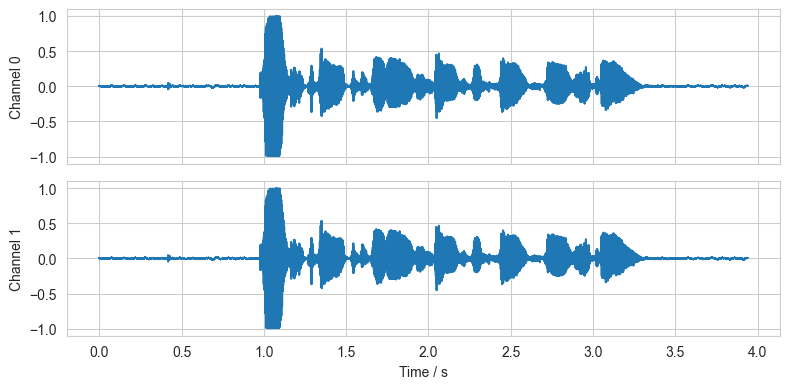

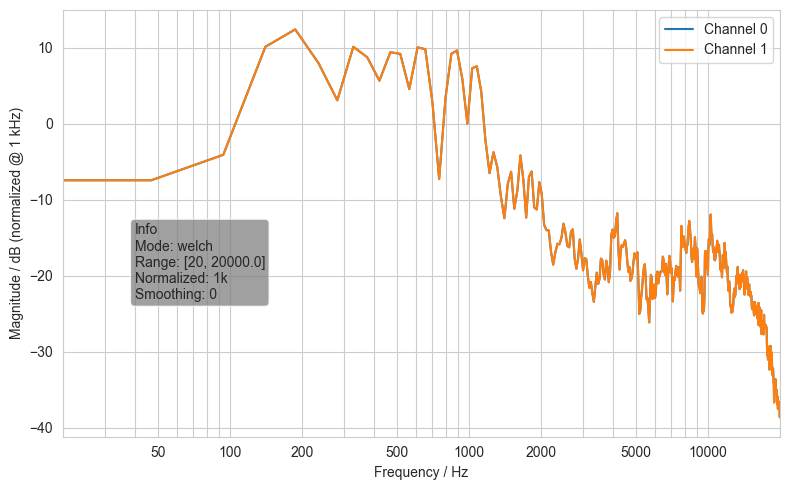

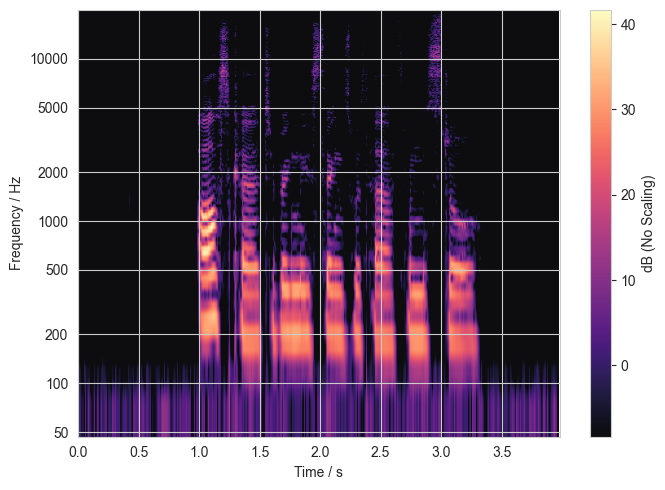

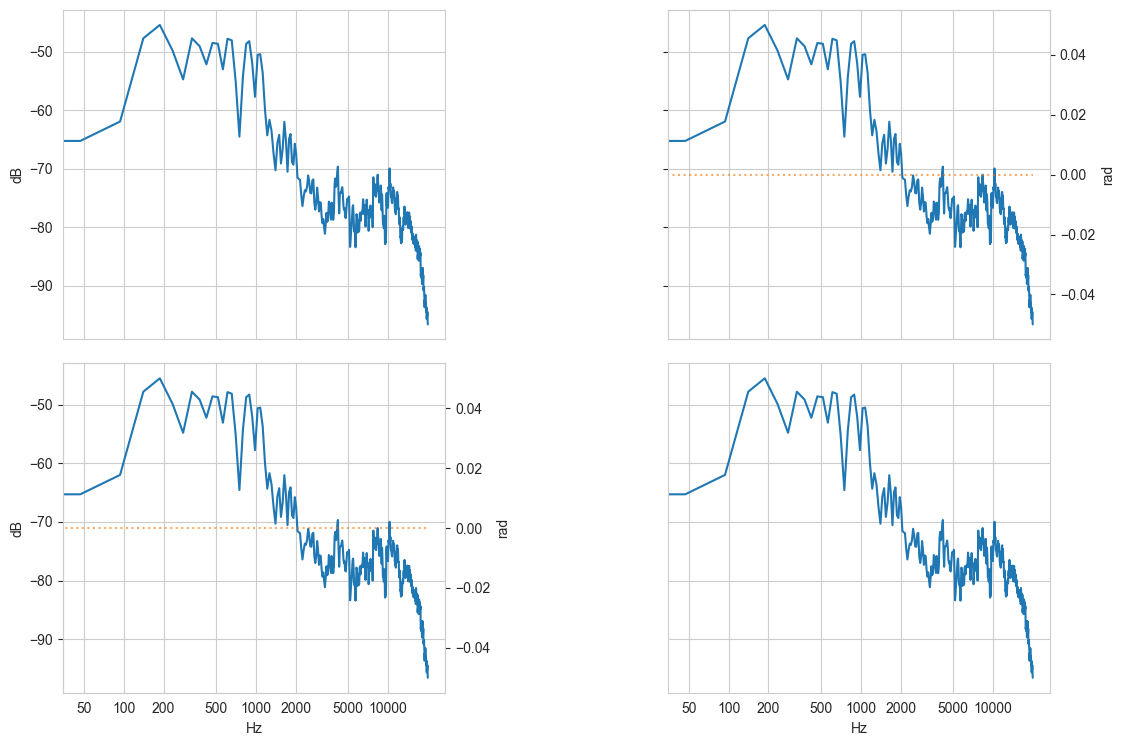

In [6]:
# ========== Time signal ======================================================
fig, ax = speech.plot_time()

# ========== Magnitude spectrum ===============================================
speech.plot_magnitude(
    range_hz=[20, 20e3],
    normalize='1k',  # Options are 1k, max, `None`
    range_db=None,
    smoothe=0,  # Smoothing across (1/smoothe)-octave band. 0 is no smoothing.
    show_info_box=True,  # Little info box within the plot
)

# ========== Spectrogram ======================================================
speech.plot_spectrogram(
    channel_number=0,
    logfreqs=True,  # Frequency axis with logarithmic spacing
)

# ========== CSM ==============================================================
fig, ax = speech.plot_csm(
    range_hz=[20, 20e3],
    logx=True,  # Frequency axis logarithmic
    with_phase=True,  # Phase within same plots
)
fig.set_size_inches(14, 8)  # Getting a better size for notebook

# For showing the plots:
dsp.plots.show()

# Other plotting methods: plot_phase, plot_group_delay, plot_coherence.
# See documentation for more information about them.

In [7]:
# Other methods:
speech.swap_channels(new_order=[1, 0])

## 2. The `MultiBandSignal` class

This class contains a multi-band signal with multirate capabilities.

In [8]:
mbs = dsp.MultiBandSignal(
    bands=None,  # List or tuple containing the Signals
    same_sampling_rate=True,  # When False, different sampling
                              # rates for each band are possible
    info={'README': 'Example multiband signal'}  # Generic information
)

Notes:
- `bands` is a list or tuple and contains `Signal` elements corresponding to each band of the signal. When same_sampling_rate is set to True, all signals should have the same length.

In [9]:
# Use filterbanks only for demonstration of MultiBandSignal, see examples
# for filterbanks further below
fb = dsp.filterbanks.linkwitz_riley_crossovers(
    [2000], 6, sampling_rate_hz=speech.sampling_rate_hz)
speech_bands = fb.filter_signal(speech)
# Filtering with a FilterBank (with mode='parallel') returns a MultiBandSignal
print(type(speech_bands))

<class 'dsptoolbox.classes.multibandsignal.MultiBandSignal'>


/Users/neumanndev/opt/anaconda3/envs/dsp-dev11/lib/python3.11/site-packages/dsptoolbox/classes/signal_class.py:172: UserWarning: Signal was over 0 dBFS, normalizing to 0 dBFS peak level was triggered
  warn('Signal was over 0 dBFS, normalizing to 0 dBFS ' +


In [10]:
# ========== Add bands ========================================================
speech_bands.add_band(
    sig=speech_bands.bands[1],
    index=-1  # Place to insert band
)

# ========== Remove bands =====================================================
speech_bands.remove_band(
    index=-1,
    return_band=False  # When True, the deleted band is returned
)

# ========== Collapse =========================================================
# Collapses MultiBandSignal into a Signal object by summing up all bands
speech_collapsed = speech_bands.collapse()

# ========== Show information =================================================
speech_bands.show_info(
    show_band_info=True  # Longer message
)

# Other methods: save_signal, copy, get_all_bands


Multiband signal: | Number of bands: 2 | Same sampling rate: True | Signal type: general | Sampling rate hz: 48000 | Band length samples: 189056 | Number of channels: 2 | Readme: MultiBandSignal made using Linkwitz-Riley filter bank | Filterbank freqs: [2000] | Filterbank order: [6.]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Signal 0: | Sampling rate hz: 48000 | Number of channels: 2 | Signal length samples: 189056 | Signal length seconds: 3.9386666666666668 | Signal type: general | Signal id: 

Signal 1: | Sampling rate hz: 48000 | Number of channels: 2 | Signal length samples: 189056 | Signal length seconds: 3.9386666666666668 | Signal type: general | Signal id: 



## 3. The `Filter` class

`Filter` hosts a digital filter and all the necessary metadata to generate it and use it. The general preferred method of filtering is SOS (second order sections) since, according to scipy's documentation, it is more numerically stable. Nevertheless, using transfer functions (b and a filter coefficients) is also supported and preferred for long FIR filters.

The backend used for filtering and filter design is almost completely based on `scipy.signal`. Please refer to its [documentation](https://docs.scipy.org/doc/scipy/reference/signal.html#spectral-analysis) for understanding what is happening "behind curtains".

In [11]:
fc = dict(eq_type='lowshelf', freqs=2000, gain=3, q=1)
ft = dsp.Filter(
    filter_type='biquad',
    filter_configuration=fc,  # Dictionary with filter configuration
    sampling_rate_hz=48000
)

Notes:
- The `Filter` class has an extensive constructor. See documentation for details.

In [12]:
# ========== Get coefficients =================================================
sos = ft.get_coefficients(mode='sos')

# ========== Initialize filter values =========================================
ft.initialize_zi(
    number_of_channels=1
)

# ========== Get impulse response of filter ===================================
ir_of_filter = ft.get_ir(length_samples=512)

# ========== Show Info ========================================================
ft.show_info()

# Other methods: copy, save_filter, set_filter_parameters, get_filter_metadata

Filter – ID: None
------------------
Eq type: Lowshelf
Freqs: 2000
Gain: 3
Q: 1
Order: 2
Sampling rate hz: 48000
Filter type: biquad
Preferred method of filtering: sos
Filter id: None



#### Plotting in `Filter`

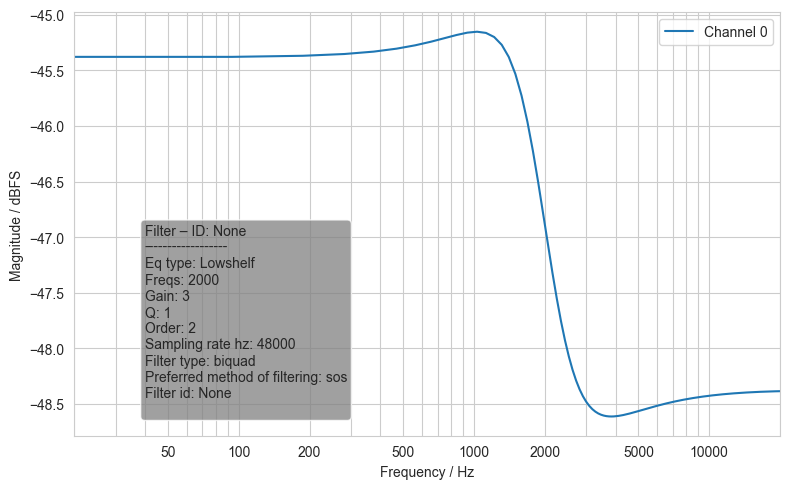

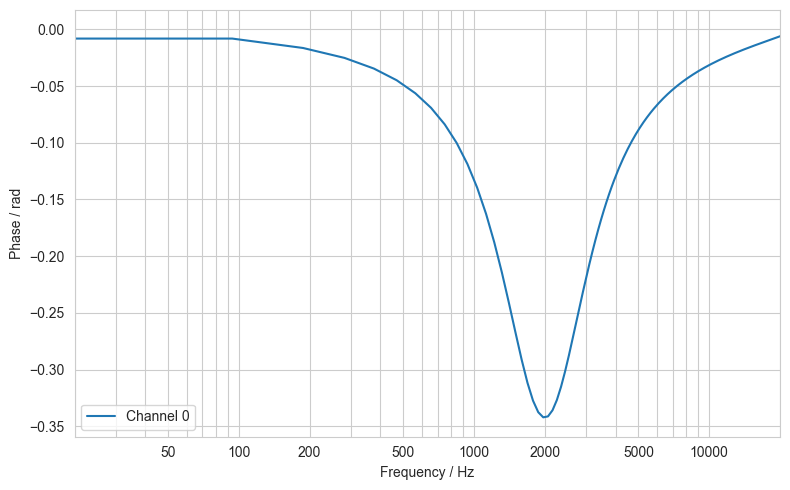

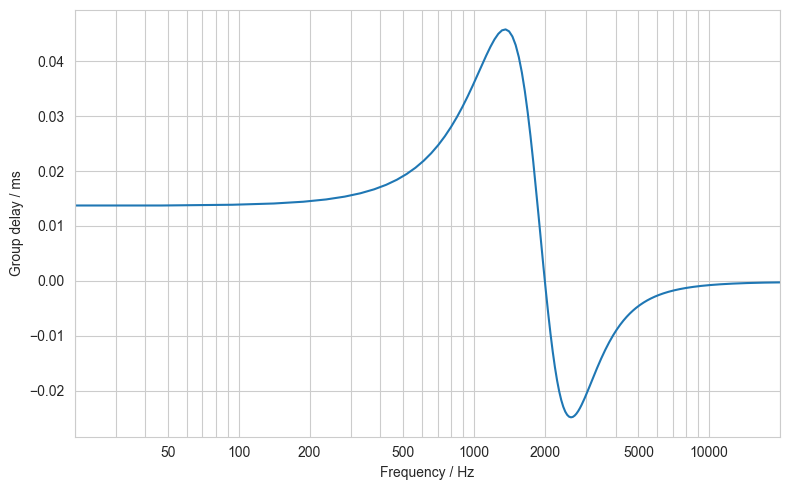

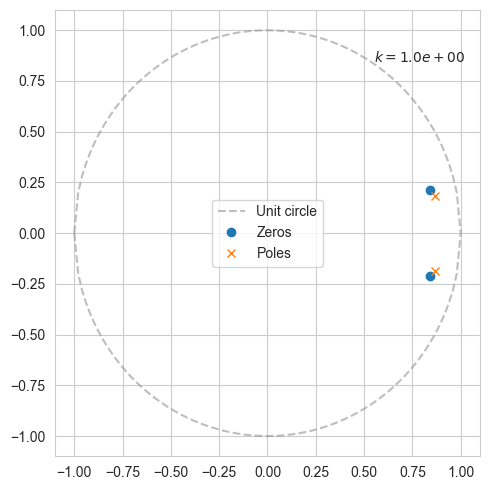

In [13]:
# ========== Plot magnitude spectrum ==========================================
ft.plot_magnitude()

# ========== Plot phase spectrum ==============================================
ft.plot_phase()

# ========== Plot group delay =================================================
ft.plot_group_delay()

# ========== Plot zeros and poles =============================================
ft.plot_zp()

dsp.plots.show()

#### Filtering

In [14]:
new_speech = ft.filter_signal(
    speech,
    channels=None,  # `None` means all channels are filtered
    activate_zi=False  # Uses filter initial values and updates them
)

## 4. The `FilterBank` class

`FilterBank` contains a collection of filters and all their metadata.

Different filtering methods are also contained. When using the method `filter_signal`, the `mode` parameter defines the behaviour. These are the available options:
1. `'parallel'`: Each filter is applied to the input signal sepparately and the output is a `MultiBandSignal` where the number of bands matches the number of filters.
2. `'sequential'`: Each filter is applied to the signal sequentially and the output is a `Signal` with same dimensions as the input.
3. `'summed'`: Each filter is applied sepparately to the `Signal` and all the bands are summed in the end.

In [15]:
# Constructor
fb = dsp.FilterBank(
    filters=[],
    same_sampling_rate=True,
    info={}
)

# Creates filter bank from available presets
fb = dsp.filterbanks.reconstructing_fractional_octave_bands(
    sampling_rate_hz=speech.sampling_rate_hz)

# ========== Add filter =======================================================
fb.add_filter(
    filt=ft,
    index=-1  # Insert in last position
)

# ========== Remove filter ====================================================
fb.remove_filter(index=-1, return_filter=False)

# ========== Show info ========================================================
fb.show_info(show_filter_info=True)

# Other: copy, save_filterbank


Filter Bank: | Number of filters: 9 | Same sampling rate: True | Sampling rate hz: 48000 | Types of filters: ('fir',)
---------------------------------------------------------------------------------------------------------------------
Filter 0: | Order: 2047 | Sampling rate hz: 48000 | Filter type: fir | Preferred method of filtering: ba | Filter id: None

Filter 1: | Order: 2047 | Sampling rate hz: 48000 | Filter type: fir | Preferred method of filtering: ba | Filter id: None

Filter 2: | Order: 2047 | Sampling rate hz: 48000 | Filter type: fir | Preferred method of filtering: ba | Filter id: None

Filter 3: | Order: 2047 | Sampling rate hz: 48000 | Filter type: fir | Preferred method of filtering: ba | Filter id: None

Filter 4: | Order: 2047 | Sampling rate hz: 48000 | Filter type: fir | Preferred method of filtering: ba | Filter id: None

Filter 5: | Order: 2047 | Sampling rate hz: 48000 | Filter type: fir | Preferred method of filtering: ba | Filter id: None

Filter 6: | Order: 

#### Plotting with `FilterBank`
Different filter modes generate different plots, see documentation for details.

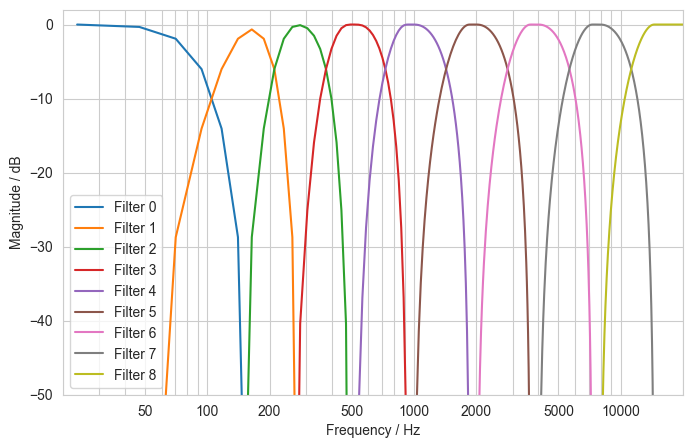

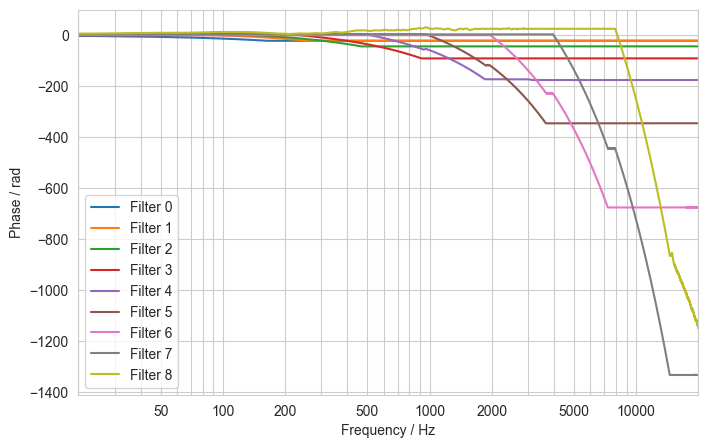

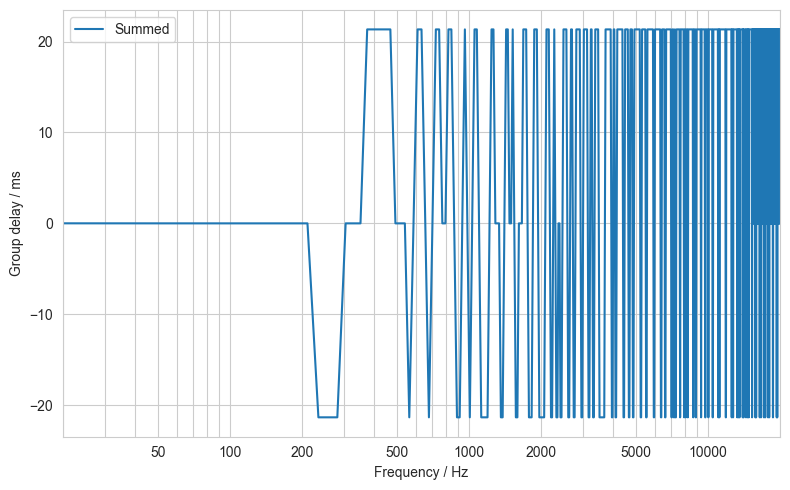

In [16]:
# ========== Plot magnitude spectra ===========================================
fb.plot_magnitude(
    mode='parallel',
    range_hz=[20, 20e3],
    test_zi=False,
)

# ========== Plot phase spectra ===============================================
fb.plot_phase(
    mode='parallel',
    range_hz=[20, 20e3],
    test_zi=False,
    unwrap=True,
)

# ========== Plot group delay =================================================
fb.plot_group_delay(
    mode='summed',  # Summed signal
    range_hz=[20, 20e3],
    test_zi=False,
)

dsp.plots.show()

#### Filtering

In [17]:
speech_filt = fb.filter_signal(
    speech,
    mode='parallel',  # Other options are 'sequential', 'summed'
    activate_zi=False
)

speech_filt.show_info()


Multiband signal: | Number of bands: 9 | Same sampling rate: True | Signal type: general | Sampling rate hz: 48000 | Band length samples: 189056 | Number of channels: 2



# Wrapping up
The classes contained in `dsptoolbox` were demonstated here. For further details, refer to the documentation or the source code.

Remarks:
- The `linkwitz_riley_crossovers` is a special crafted filter bank class because the implementation is somewhat special. It contains all the same methods as the `FilterBank` class and the API is the same so that the end user might not even notice the difference.